In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 27.4MB/s 
     |████████████████████████████████| 204kB 49.2MB/s 
     |████████████████████████████████| 1.2MB 57.7MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 
     |████████████████████████████████| 61kB 9.8MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
Mounted at /content/gdrive


In [2]:
from fastbook import *
from fastai.vision.all import *

# Multi-label Classification

## Data

In [3]:
path = untar_data(URLs.PASCAL_2007)

In [6]:
(path).ls()

(#8) [Path('/root/.fastai/data/pascal_2007/train'),Path('/root/.fastai/data/pascal_2007/test.csv'),Path('/root/.fastai/data/pascal_2007/test'),Path('/root/.fastai/data/pascal_2007/train.json'),Path('/root/.fastai/data/pascal_2007/segmentation'),Path('/root/.fastai/data/pascal_2007/test.json'),Path('/root/.fastai/data/pascal_2007/valid.json'),Path('/root/.fastai/data/pascal_2007/train.csv')]

In [7]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


## Constructing a DataBlock and DataLoaders

In [8]:
def splitter_function(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train, valid

images = DataBlock(
    blocks = (ImageBlock, MultiCategoryBlock),
    get_x = lambda r: path/'train'/r['fname'],
    get_y = lambda r: r['labels'].split(),
    splitter = splitter_function,
    item_tfms = RandomResizedCrop(128, min_scale=0.35)
)

In [10]:
dls = images.dataloaders(df)

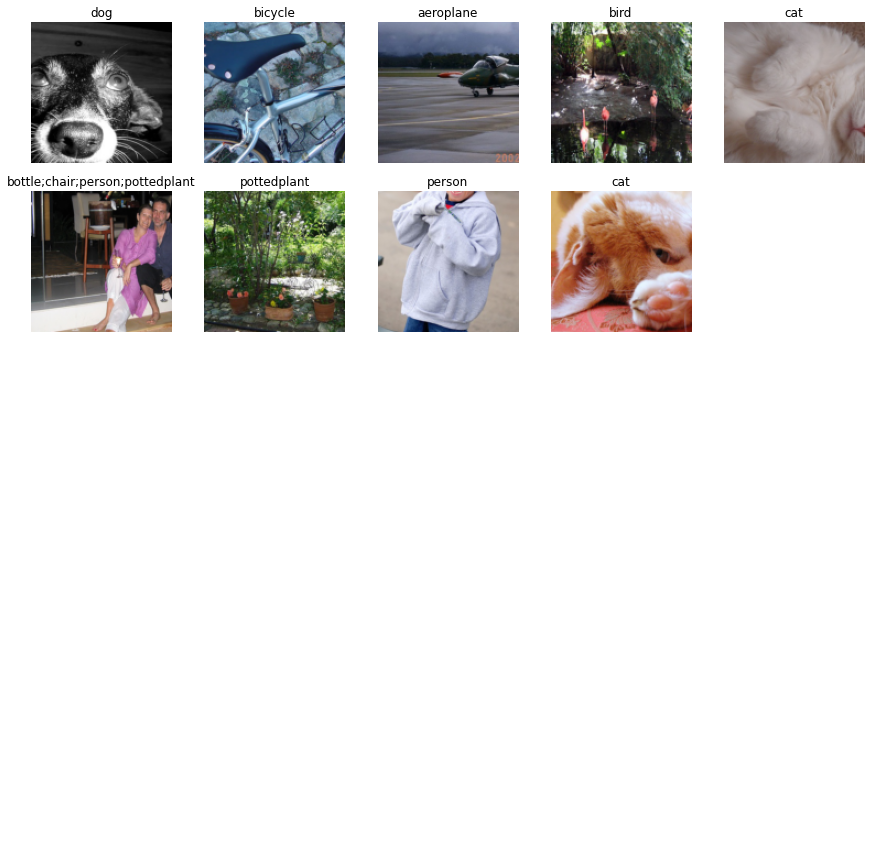

In [ ]:
dls.show_batch(nrows=5, ncol)